<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li><li><span><a href="#Скользящая-средняя,-проверка-на-стационарность" data-toc-modified-id="Скользящая-средняя,-проверка-на-стационарность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Скользящая средняя, проверка на стационарность</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Добавление-признаков" data-toc-modified-id="Добавление-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Добавление признаков</a></span></li><li><span><a href="#Создание-обучающей-и-тестовой-выборок" data-toc-modified-id="Создание-обучающей-и-тестовой-выборок-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Создание обучающей и тестовой выборок</a></span></li><li><span><a href="#Обучение-моделей-с-помощью-пайплайна" data-toc-modified-id="Обучение-моделей-с-помощью-пайплайна-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение моделей с помощью пайплайна</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоговые-выводы" data-toc-modified-id="Итоговые-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговые выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Наша задача** - построить модель для предсказания количества заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Описание данных**

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`

**План работы будет таким:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Прежде чем загружать датасеты, нужно провести импорт необходимых библиотек и до.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.dummy import DummyRegressor

RANDOM_STATE = 42

Кроме того, напишем функции, которые пригодятся нам в дальнейшей работе.

In [ ]:
# Функция получения общей информации о датасете, о дубликатах и пропусках.
def information(df):
    df.info();
    print('\nКоличество дубликатов:',df.duplicated().sum(),'\n')
    print('Количество пропусков:\n',df.isna().sum())

In [ ]:
# Функция создания дополнительных признаков (день, день недели, час, смещение, скользящая средняя).
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour

    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new

## Подготовка

### Загрузка данных

Попробуем загрузить датасет, сразу переведем формат данных в колонке с датой и временем в нужный фомат и сделаем эту колонку индексом.

In [ ]:
try:
    data = pd.read_csv('/???/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://???/taxi.csv', index_col=[0], parse_dates=[0])

Посмотрим первые 5 строк датасета.

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Посмотрим общую информацию о датасете.

In [ ]:
information(data)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB

Количество дубликатов: 26415 

Количество пропусков:
 num_orders    0
dtype: int64


В данном случае на дубликаты можно не обращать внимание, ведь у нас всего одна колонка с данными.

### Подготовка данных

Отсортируем индекс, чтобы даты и время шли по порядку.

In [ ]:
data.sort_index(inplace=True)
data.index.is_monotonic

True

Проведем ресемплирование данные в датасете по одному часу.

In [ ]:
data = data.resample('1H').sum()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


***Выводы:*** Мы провели загрузку данных, выяснили, что датасет состоит из 26496 строк, пропусков в данных нет. После ресемплирования количество строк уменьшилось до 4416.

## Анализ

### Тренды и сезонность

Начнем анализ наших данных с трендов и сезонности.

In [ ]:
decomposed = seasonal_decompose(data)

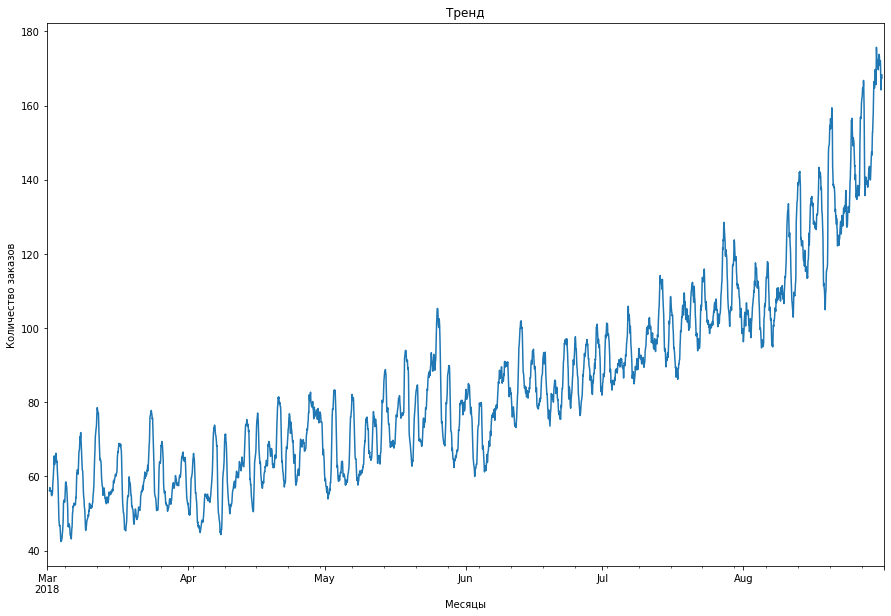

In [ ]:
decomposed.trend.plot(title='Тренд', xlabel='Месяцы', ylabel='Количество заказов',figsize=(15,10));

Видно, что тренд в повышении количества заказов такси от начала весны к концу лета.

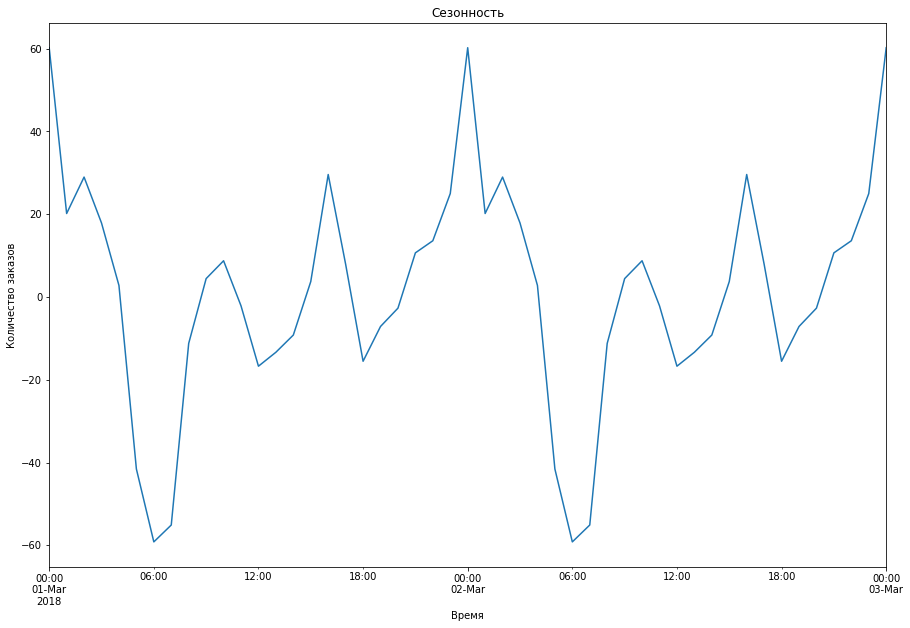

In [ ]:
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-03 00:00:00'].plot(title='Сезонность', xlabel='Время',
                                                                      ylabel='Количество заказов', figsize=(15,10));

При анализе сезонности можно выявить циклично повторяющиеся закономерности во временном ряду. В данном случае мы видим закономерности по количеству заказов в зависимости от времени суток. Максимальное число заказов ежедневно около полуночи, затем к утру количество резко уменьшается, затем снова идет подъем к обеду, еще один пик в районе 17 часов и подъем к полуночи. Думаю, такая закономерность связана с расписанием полетов аэропорта.

### Скользящая средняя, проверка на стационарность

Теперь посмотрим скользящую среднюю на интервале в одну неделю, шаг сделаем 24 часа.

In [ ]:
data2 = data['2018-03-01 00:00:00':'2018-03-08 23:00:00'].resample('1H').sum()
data2['rolling_mean'] = data2.shift().rolling(24).mean()

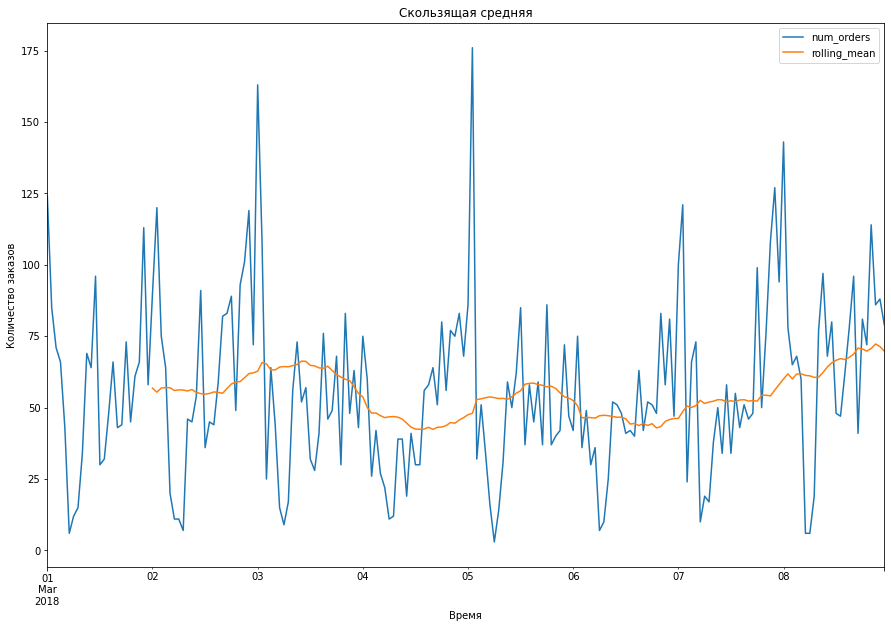

In [ ]:
data2.plot(title='Скользящая средняя', xlabel='Время', ylabel='Количество заказов', figsize=(15,10));

График очень похож на график нестационарного временного ряда. Но нужно в этом убедиться. Для этого воспользуемся тестом Дики-Фуллера.

In [ ]:
result = adfuller(data['num_orders'], autolag='AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["1%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Нулевая гипотеза не отвергнута – Временной ряд не стационарен


Исходный временной ряд не является стационарным, а значит для обучения нужно будет добавлять новые признаки со смещением, чтобы привести временной ряд к стационарности.

***Выводы:*** Мы провели анализ временных рядов наших данных. Изучили тренды, сезонность, построили скользящую кривую и проверили временной ряд на стационарность. Видно, что тренд в повышении количества заказов такси от начала весны к концу лета, а сезонность в течение дня связана с расписанием полетов аэропорта.

## Обучение

### Добавление признаков

Для того, чтобы модели было, на чем обучаться, в датасет необходимо добавить признаки. В нашем случае это колонки с указанием дня, дня недели, часа, стационарные ряды, данные скользящей средней. Стационарных рядов возьмем 24 по количество часов в сутках, а также учитывая анализ сезонности. Для создания признаков воспользуемся функцией, которая написана выше.

In [ ]:
data_new=make_features(data, 24, 24)

### Создание обучающей и тестовой выборок

Теперь нужно провести разделение датасета на обучающую и тестовую выборки. Для тестовой выборки оставим 10% от всего датасета. Отделим целевой признак (количество заказов).

In [ ]:
train, test = train_test_split(data_new, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(('num_orders'), axis=1)
y_train = train['num_orders']
X_test = test.drop(('num_orders'), axis=1)
y_test = test['num_orders']

### Обучение моделей с помощью пайплайна

Чтобы сравнить несколько моделей, удобно использовать пайплайн с перебором разных гиперпараметров в GridsearchCV. Так как целевой признак у нас непрерывный количественный, то для для обучения будем брать модели регрессии: линейную регрессию, дерево решений и модель градиентного бустинга LightGBM (для дерева решений и LightGBM используем перебор разных гиперпараметров). В качестве метрики используем RMSE.

In [ ]:
pipe_final = Pipeline(
        [
            ('models', DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=8, max_features=8))
        ]
    )

In [ ]:
param_grid = [

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(6, 9),
        'models__max_features': range(6, 9)
    },
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [50,100],
        'models__max_depth': range(2, 6)
    },
    {
        'models': [LinearRegression()]
    }
]

Запустим обучение перебором, используя метод GridSearchCV.

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)
grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('models',
                                        DecisionTreeRegressor(max_depth=8,
                                                              max_features=8,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(6, 9),
                          'models__max_features': range(6, 9)},
                         {'models': [LGBMRegressor(random_state=42)],
                          'models__max_depth': range(2, 6),
                          'models__n_estimators': [50, 100]},
                         {'models': [LinearRegression()]}],
             scoring='neg_root_mean_squared_error')

Теперь выберем лучшую модель и посмотрим ее метрику.

In [ ]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика RMSE лучшей модели на кросс-валидации:', grid.best_score_*-1)

Лучшая модель и её параметры:

 Pipeline(steps=[('models', LGBMRegressor(max_depth=3, random_state=42))])
Метрика RMSE лучшей модели на кросс-валидации: 26.304047294894602


Лучшей моделью получилась модель LightGBM с максимальной глубиной - 4 и количеством деревьев - 100.

### Анализ моделей



Для анализа моделей выведем таблицу с лучшими результатами моделей. Для этого сгруппируем результаты по названию модели и минимальному значению RMSE. Оставим в таблице только гиперпараметры лучших экземпляров моделей, а также время обучения и время предсказания.

In [ ]:
res = pd.DataFrame(grid.cv_results_)
res.mean_test_score = res.mean_test_score * -1
res['param_models'] = res['param_models'].astype('category')
t=res.pivot_table(index='param_models', values='mean_test_score', aggfunc='min')
t.columns = ['min_rmse']
res1=t.merge(res, left_on='min_rmse', right_on='mean_test_score', how='left')
res1.drop(['std_fit_time', 'std_score_time', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'], axis=1)

,min_rmse,mean_fit_time,mean_score_time,param_models,param_models__max_depth,param_models__max_features,param_models__n_estimators
0,31.881602,0.010326,0.002247,DecisionTreeRegressor(random_state=42),7,8,NaN
1,26.304047,1.576701,0.086861,LGBMRegressor(random_state=42),3,NaN,100
2,27.796919,0.070695,0.030004,LinearRegression(),NaN,NaN,NaN


Видно, что на обучающей выборке модель LightGBM ненамного лучше двух других моделей.

***Выводы:*** Мы добавили новые признаки и провели обучение нескольких моделей с разными гиперпараметрами, используя пайплайн и метод GridSearchCV. Лучшей моделью получилась модель LightGBM с максимальной глубиной - 3 и количеством деревьев - 100, показавшая метрику RMSE 26,3.

## Тестирование

Посмотрим, какой результат покажет модель LightGBM на тестовой выборке.

In [ ]:
pred = grid.best_estimator_.predict(X_test)
print("RMSE тестовой выборки:", root_mean_squared_error(y_test, pred))

RMSE тестовой выборки: 42.99158441228548


Значение метрики RMSE получилось 42.9, что укладывается в критерии заказчика, так что будем рекомендовать заказчику именно эту модель.

Визуализируем предсказания лучшей модели и сравним их с правильными ответами на графике.

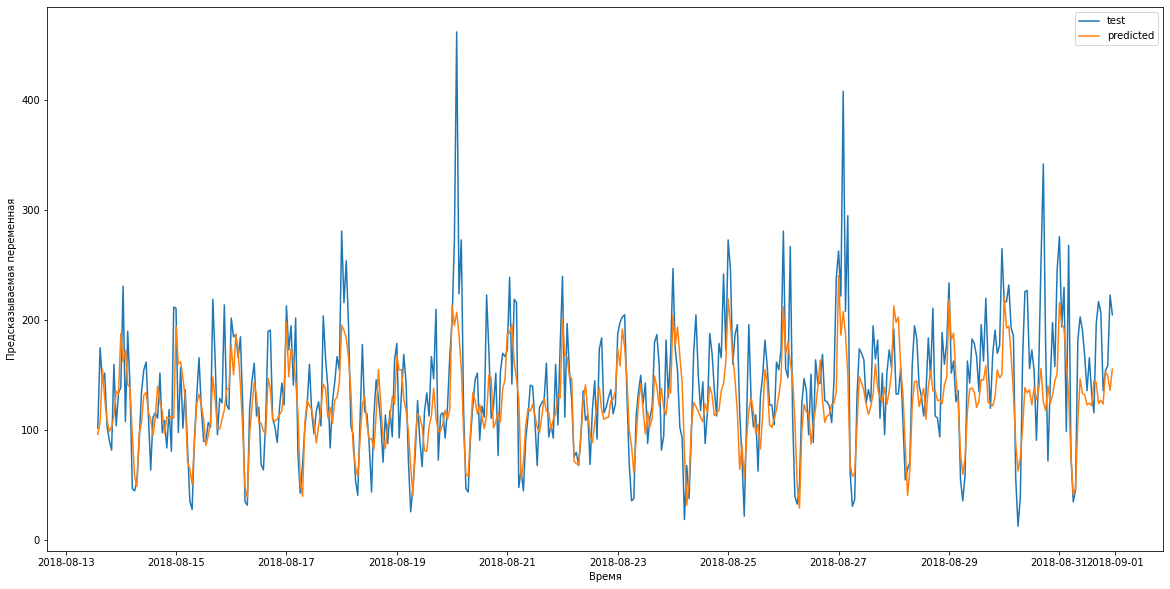

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(y_test, label='test')
ax.plot(y_test.index, pred, label='predicted')
ax.set_xlabel('Время')
ax.set_ylabel('Предсказываемая переменная')
plt.legend()
plt.show()

Видно, что модель плохо справляется с предсказанием пиковых нагрузок (больше 200 заказов такси в час), кроме того больше ошибок становится ближе к концу графика, при этом в начале графика ошибок гораздо меньше, а ведь задача заказчика как раз состоит в предсказании количества заказов на следующий час, с этим модель справляется хорошо.

Проверим лучшую модель на адекватность, сравнив ее предсказания с качеством модели, которая предсказывает константу. Для этого используем модель DummyRegressor.

In [ ]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
y_pred = dummy_regr.predict(X_test)
root_mean_squared_error(y_test, y_pred)

84.6499381993622

Результат константной модели на тестовой выборке получился 84.6, что намного хуже модели LightGBM.

## Итоговые выводы

Мы провели работу по предсказанию количества заказов такси на следующий час. На пути к выполнению этой задачи мы провели следующую работу:
 1. Провели загрузку данных, выяснили, что датасет состоит из 26496 строк, пропусков в данных нет. После ресемплирования количество строк уменьшилось до 4416.
 2. Провели анализ временных рядов наших данных. Изучили тренды, сезонность, построили скользящую кривую и проверили временной ряд на стационарность. Видно, что тренд в повышении количества заказов такси от начала весны к концу лета, а сезонность в течение дня связана с расписанием полетов аэропорта.
 3. Добавили новые признаки. Так как целевой признак у нас непрерывный количественный, то для для обучения взяли модели регрессии: линейную регрессию, дерево решений и модель градиентного бустинга LightGBM (для дерева решений и LightGBM используем перебор разных гиперпараметров). В качестве метрики использовали RMSE. Провели обучение нескольких моделей с разными гиперпараметрами, используя пайплайн и метод GridSearchCV. Лучшей моделью получилась модель LightGBM с максимальной глубиной - 3 и количеством деревьев - 100, показавшая метрику RMSE 26,3.
 4. Для анализа моделей вывели таблицу с результатами всех обученных моделей. Получили предсказания для тестовой выборки для лучшей модели, показатель RMSE у лучшей модели получился 42.9, что удовлетворяет критериям заказчика  Именно эту модель и будем рекомендовать заказчику. Дополнительно посмотрели предсказания лучшей модели и сравнили их с правильными ответами на графике. Видно, что модель плохо справляется с предсказанием пиковых нагрузок (больше 200 заказов такси в час), кроме того больше ошибок становится ближе к концу графика, при этом в начале графика ошибок гораздо меньше, а ведь задача заказчика как раз состоит в предсказании количества заказов на следующий час, с этим модель справляется хорошо.
